In [72]:
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib
import time 
import pandas as pd 
import seaborn as sns 
sns.set()

# Gridworld

![title](grid.png)


# Helper Functions

In [177]:
def plot_graph (df, title, x_label, y_label):
    sns.set(rc = {'figure.figsize':(15,5)})
    f = sns.lineplot(data=df)
    f.set_xlabel(x_label, fontsize = 15)
    f.set_ylabel(y_label, fontsize = 15)
    f.set_title(title)

# Define States and Actions

In [10]:
S = list(range(0,36))
A = list(range(0,36))

### Define legal moves
Agent must move to an adjacent location during each turn. It cannot decide to stay in the same location.

In [12]:
possible_actions = []

for row in range(0,6):
    for col in range(0, 6):
        current = row * 6 + col

        if col > 0:
            left = current - 1
            possible_actions.append((current, left))
        if col < 5:
            right = current + 1
            possible_actions.append((current, right))
        if row > 0:
            up = current - 6
            possible_actions.append((current, up))
        if row < 5:
            down = current + 6
            possible_actions.append((current, down))

print("# possible moves:", len(possible_actions))            
#print(possible_actions)

# possible moves: 120


In [13]:
walls = [(3,4), (3,9), (4,5), (11,17), (17,23), (12,18), (18,24), (30,31), (27,33), (29,35)]

illegal_moves = [] 

for wall in walls:
    illegal_moves.append((wall[0], wall[1]))
    illegal_moves.append((wall[1], wall[0]))
    
print("# illegal moves:", len(illegal_moves))
#print(illegal_moves)

# illegal moves: 20


In [14]:
for illegal_move in illegal_moves:
    possible_actions.remove(illegal_move)

print("# legal moves:", len(possible_actions))


# legal moves: 100


# Define Rewards Matrix

In [15]:
DEFAULT_REWARD = 0
REWARD = 100
REWARD_LOC = [5, 16, 19]
PENALTY = -25
PENALTY_LOC = [8, 17, 34] 
DST_REWARD = 1000 
START = 0 
DST = 35

In [178]:
R = np.empty((len(A), len(S)))
R[:] = np.nan

highlight_cells = []

for action in possible_actions:    
    if action[1] in REWARD_LOC: # Rewards
        R[action[0], action[1]] = REWARD
    elif action[1] in PENALTY_LOC: # Penalties
        R[action[0], action[1]] = PENALTY 
    elif action[1] == DST:  #destination
        R[action[0], action[1]] = DST_REWARD
    else:
        R[action[0], action[1]] = DEFAULT_REWARD



#  Policies

In [31]:
def decay_eps_greedy(eps, all_actions, best_actions): 
    if np.random.uniform() > eps:
        #explore
        a = np.random.choice(all_actions)
    else:
        #exploit 
        a = np.random.choice(best_actions)
        
    return a
    

# Q-learning function

In [148]:
def run_q_learning(num_episodes, rewards_matrix, steps, alpha, gamma, policy, policy_args):
    time_start = time.time()
    
    #Initialize Q matrix 
    R = rewards_matrix
    Q = np.zeros(R.shape)
    rewards_per_episode = []
    steps_per_episode = []
    found_flag = 0 
    
     #set up based on policy 
    if policy == 'eps_greedy':
        eps_start = policy_args.pop('eps_start')
        eps_end = policy_args.pop('eps_end')

    for i in range(num_episodes):    
        # Initialize State
        s = 0 #np.random.choice(len(S)) #0
        
        total_reward = 0

        if i%100 == 0 and logger:
            print('Running episode {} ....'.format(i))
        
        #reinitialize epsilon each episode?     
        eps = np.linspace(eps_start, eps_end, steps)  

                
        for step in range(steps):
            available_actions = np.where(~np.isnan(R[s]))[0]
            q_values = [Q[s,a] for a in available_actions]

            best_actions = available_actions[np.where(q_values == np.max(q_values))[0]]
            if logger: print(f"Currently at {s}. best actions: {best_actions}. Step: {step}")
            best_actions_q_values = [Q[s,x] for x in best_actions]
            
            if policy == "eps_greedy": 
          
                a = decay_eps_greedy(eps[step], available_actions, best_actions)
              
                if logger: print(f"choose: {a}")
            else:
                pass
            
            r = R[s,a]
            
            if a in REWARD_LOC or a == DST  : # Reward/Finish found
                if logger: print(f"Found reward. Adding {max((r - step),0) }")
                total_reward += max((r - step),0)  # Discount reward based on steps
            else: #penalty or normal step 
                total_reward += r
            
            if logger: print(f"new reward total: {total_reward}")
            s_old = s
            s = a 

            # Q value updating
            q_updated = Q[s_old,a] + alpha * ( r + gamma * np.max(Q[s,:]) - Q[s_old,a])
            
            if Q[s_old,a] != q_updated and logger: 
                print(f"Old q value: { Q[s_old,a]}, new Q value: {q_updated}")
                
            Q[s_old,a] = q_updated


            if S[s] == DST: # Destination Reached
                rewards_per_episode.append(total_reward)
                steps_per_episode.append(step)
                found_flag += 1 
                #print('epsilon: ', epsilon)
                break
            elif step == (steps -1): #out of steps
                rewards_per_episode.append(total_reward)
                steps_per_episode.append(step)

    print(f"time elapsed for {num_episodes} epsiodes : {time.time()-time_start} s")
        
    return rewards_per_episode, steps_per_episode, found_flag, Q
                

In [150]:
# Run small batch
logger = False
policy = 'eps_greedy'
num_eps = 1
rewards_per_episode, steps_per_episode, found_flag, Q = run_q_learning(num_eps, R, 1000, 1, 0.8, policy, {'eps_start' : 0 , 'eps_end' : 0})
#print(f"Rewards per episode: {rewards_per_episode}")
#print(f"Steps per episode: {steps_per_episode}")
print(f"Num of times terminal state found: {found_flag}")
logger = False

time elapsed for 1 epsiodes : 0.028978586196899414 s
Num of times terminal state found: 1


# Evaluate epsilon-greedy  

## Epsilon-Greedy: Epsilon-greedy vs Decaying Epsilon Greedy  

set alpha = 1, gamma = 0.8

#https://www.manifold.ai/exploration-vs-exploitation-in-reinforcement-learning

In [117]:
num_eps = 600
policies = [#'greedy', 
            'eps_greedy', "eps_greedy_decay"]
df_rewards = pd.DataFrame(columns = policies )
df_steps = pd.DataFrame(columns = policies)

#greedy - doesn't converge :( 
#rewards_per_episode, steps_per_episode, found_flag, Q = run_q_learning(num_eps, R, 1000, 1, 0.8, policy, {'eps_start' : 0 , 'eps_end' : 0})
#df_rewards['greedy'] = rewards_per_episode 
#df_steps['greedy'] = steps_per_episode 

#eps_greedy
rewards_per_episode, steps_per_episode, found_flag, Q = run_q_learning(num_eps, R, 1000, 1, 0.8, policy, {'eps_start' : 0.5 , 'eps_end' : 0.5})
df_rewards['eps_greedy'] = rewards_per_episode 
df_steps['eps_greedy'] = steps_per_episode

#decaying eps_greedy
rewards_per_episode, steps_per_episode, found_flag, Q = run_q_learning(num_eps, R, 1000, 1, 0.8, policy, {'eps_start' : 0.9 , 'eps_end' : 0.1})
df_rewards['eps_greedy_decay'] = rewards_per_episode 
df_steps['eps_greedy_decay'] = steps_per_episode

Running episode 0 ....
Running episode 100 ....
Running episode 200 ....
Running episode 300 ....
Running episode 400 ....
Running episode 500 ....
time elapsed for 600 epsiodes : 1.855940580368042 s
Running episode 0 ....
Running episode 100 ....
Running episode 200 ....
Running episode 300 ....
Running episode 400 ....
Running episode 500 ....
time elapsed for 600 epsiodes : 0.8400344848632812 s


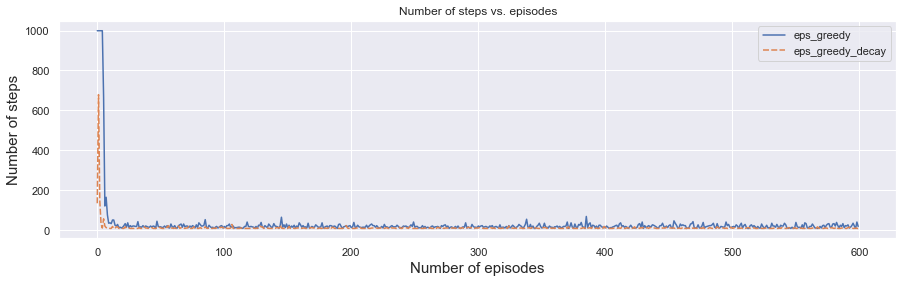

In [125]:
plot_graph(df_steps, "Number of steps vs. episodes", "Number of episodes", "Number of steps")

In [129]:
df_steps.describe()

,eps_greedy,eps_greedy_decay
count,600.000000,600.000000
mean,29.293333,12.370000
std,93.525178,28.483245
min,9.000000,9.000000
25%,13.000000,9.000000
50%,17.000000,9.000000
75%,23.000000,11.000000
max,999.000000,679.000000


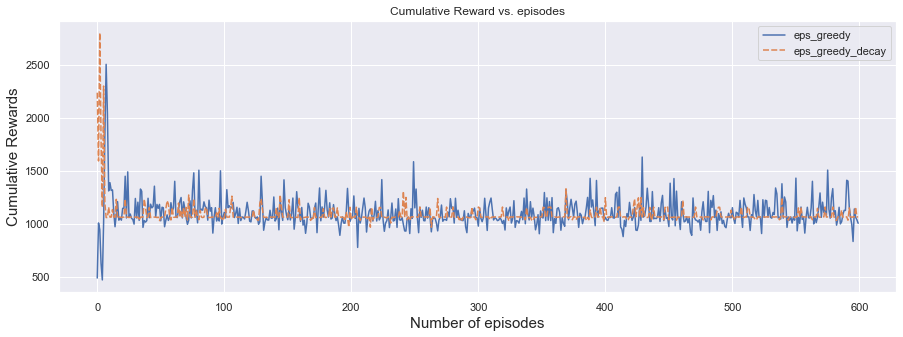

In [127]:
plot_graph(df_rewards, "Cumulative Reward vs. episodes", "Number of episodes", "Cumulative Rewards")

In [130]:
df_rewards.describe()

,eps_greedy,eps_greedy_decay
count,600.000000,600.000000
mean,1101.590000,1085.736667
std,143.829088,114.505108
min,468.000000,966.000000
25%,1030.000000,1059.000000
50%,1061.000000,1061.000000
75%,1150.000000,1063.000000
max,2503.000000,2800.000000


## Epsilon-Greedy: search for epsilon 

In [164]:
np.arange(0.3, 0.9, 0.1)
df_rewards = pd.DataFrame(columns = eps_start)
df_rewards.head()

,0.9,0.8,0.7,0.6,0.5,0.4,0.3


In [169]:
eps_start = np.arange(0.3, 0.9, 0.1) #np.linspace(0.9, 0.1, 9)
eps_end = 0.01

# np.append(eps_start, eps_end) 

num_eps = 600 
df_rewards = pd.DataFrame(columns = eps_start)
df_steps = pd.DataFrame(columns = eps_start)
df_rewards.head()

for eps in eps_start: 
    rewards_per_episode, steps_per_episode, found_flag, Q = run_q_learning(num_eps, R, 1000, 1, 0.8, policy, {'eps_start' : eps , 'eps_end' : 0.01})
    df_rewards[eps] = rewards_per_episode 
    df_steps[eps] = steps_per_episode

time elapsed for 600 epsiodes : 1.6910510063171387 s
time elapsed for 600 epsiodes : 1.2073299884796143 s
time elapsed for 600 epsiodes : 0.9924325942993164 s
time elapsed for 600 epsiodes : 0.9114925861358643 s
time elapsed for 600 epsiodes : 0.8575012683868408 s
time elapsed for 600 epsiodes : 0.6596219539642334 s
time elapsed for 600 epsiodes : 0.8305253982543945 s


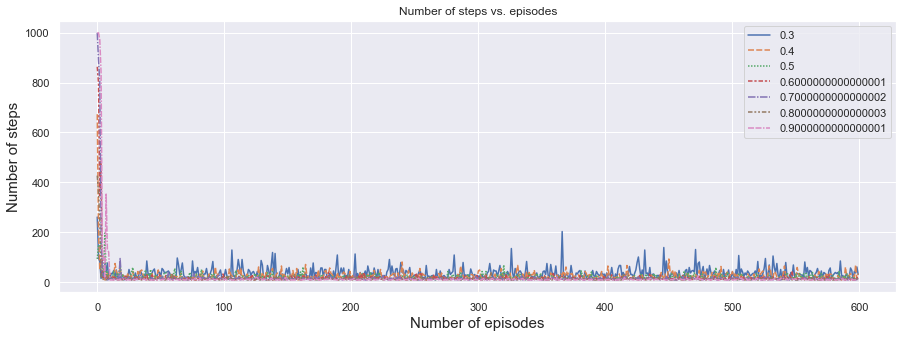

In [170]:
plot_graph(df_steps, "Number of steps vs. episodes", "Number of episodes", "Number of steps")

In [171]:
df_steps.describe()

,0.3,0.4,0.5,0.6,0.7,0.8,0.9
count,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.00000
mean,36.216667,26.543333,21.293333,20.016667,18.813333,13.540000,18.12000
std,24.444268,30.315395,15.269443,52.759191,63.337597,24.361805,78.59738
min,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.00000
25%,21.000000,17.000000,13.000000,12.500000,11.000000,9.000000,9.00000
50%,31.000000,21.000000,17.000000,15.000000,13.000000,11.000000,9.00000
75%,45.000000,31.000000,25.000000,19.000000,17.000000,13.000000,11.00000
max,261.000000,673.000000,197.000000,863.000000,999.000000,427.000000,999.00000


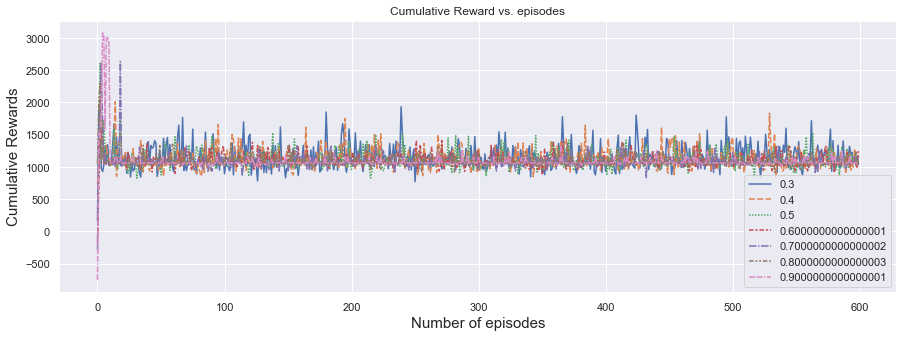

In [172]:
plot_graph(df_rewards, "Cumulative Reward vs. episodes", "Number of episodes", "Cumulative Rewards")

In [173]:
df_rewards.describe()

,0.3,0.4,0.5,0.6,0.7,0.8,0.9
count,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000
mean,1148.595000,1123.963333,1108.715000,1092.631667,1085.001667,1092.311667,1087.460000
std,189.744282,158.081619,140.698735,107.141923,134.586059,91.606518,199.918151
min,164.000000,744.000000,825.000000,-173.000000,-292.000000,908.000000,-754.000000
25%,1025.750000,1028.000000,1032.000000,1041.000000,1051.000000,1059.000000,1061.000000
50%,1112.000000,1080.500000,1061.000000,1061.000000,1061.000000,1063.000000,1063.000000
75%,1253.750000,1200.500000,1152.000000,1144.000000,1124.000000,1125.000000,1063.000000
max,1933.000000,2011.000000,2605.000000,1597.000000,2635.000000,2299.000000,3080.000000


# Epsilon-Greedy: search for alpha (learning rate) 

# Epsilon-Greedy: search for gamma (future reward impact) 

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=3a6511b9-8a19-4d42-a157-0d1715681a85' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>